In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os, zipfile, gdown
file_id="1fLKvOc2uohEcdimUemNsL05d4CND5qfq"
zip_path="/content/water_dataset.zip"
gdown.download(f"https://drive.google.com/uc?id={file_id}", zip_path, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1fLKvOc2uohEcdimUemNsL05d4CND5qfq
From (redirected): https://drive.google.com/uc?id=1fLKvOc2uohEcdimUemNsL05d4CND5qfq&confirm=t&uuid=b97302d1-0e14-4041-aae0-38837174bb66
To: /content/water_dataset.zip
100%|██████████| 68.7M/68.7M [00:00<00:00, 99.7MB/s]


'/content/water_dataset.zip'

In [3]:
extract_dir="/content/water_dataset"
os.makedirs(extract_dir, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall(extract_dir)

In [4]:
import glob
from PIL import Image
import numpy as np
image_dir="/content/water_dataset/data/images"
mask_dir="/content/water_dataset/data/labels"
image_paths=sorted(glob.glob(os.path.join(image_dir, "*tif")))
mask_paths=sorted(glob.glob(os.path.join(mask_dir, "*png")))
valid_pairs=[]
for img_path in image_paths:
  img_name=os.path.basename(img_path).replace(".tif","")
  mask_path=os.path.join(mask_dir, f"{img_name}.png")
  if not os.path.exists(mask_path):
    continue
  if "_" in os.path.basename(mask_path):
    continue
  mask=np.array(Image.open(mask_path))
  if np.max(mask)==0 or np.min(mask)==255:
    continue

  valid_pairs.append((img_path,mask_path))

print(len(valid_pairs), "valid pair")


261 valid pair


In [5]:
filenames = [os.path.basename(pair[0]) for pair in valid_pairs]
print(filenames)

['0.tif', '1.tif', '10.tif', '100.tif', '101.tif', '102.tif', '104.tif', '105.tif', '108.tif', '109.tif', '11.tif', '110.tif', '111.tif', '112.tif', '113.tif', '114.tif', '116.tif', '117.tif', '118.tif', '119.tif', '12.tif', '120.tif', '121.tif', '123.tif', '124.tif', '125.tif', '126.tif', '127.tif', '128.tif', '129.tif', '13.tif', '130.tif', '131.tif', '132.tif', '133.tif', '134.tif', '135.tif', '137.tif', '138.tif', '139.tif', '140.tif', '141.tif', '142.tif', '143.tif', '144.tif', '145.tif', '146.tif', '147.tif', '148.tif', '149.tif', '15.tif', '150.tif', '153.tif', '154.tif', '156.tif', '157.tif', '158.tif', '159.tif', '16.tif', '160.tif', '161.tif', '162.tif', '164.tif', '165.tif', '166.tif', '168.tif', '169.tif', '17.tif', '170.tif', '171.tif', '172.tif', '174.tif', '175.tif', '176.tif', '177.tif', '178.tif', '179.tif', '18.tif', '180.tif', '181.tif', '182.tif', '183.tif', '184.tif', '185.tif', '186.tif', '187.tif', '19.tif', '190.tif', '191.tif', '192.tif', '193.tif', '194.tif', 

In [6]:
def calculate_water_index(img):
  R=img[:, :, 3].astype(np.float32)
  G=img[:, :, 2].astype(np.float32)
  B=img[:, :, 1].astype(np.float32)
  water_index=(G-R)/(G+R+1e-5)
  return np.expand_dims(water_index, axis=-1)

In [7]:
!pip install tifffile

In [8]:
import tifffile as tiff
def load_img_with_index(path):
  img=tiff.imread(path).astype(np.float32)/255.0
  if img.ndim==3 and img.shape[-1]==12:
    water_index=calculate_water_index(img)
    img=np.concatenate([img,water_index],axis=-1)
  return img

In [9]:
images=[]
masks=[]

for img_path, mask_path in valid_pairs:
  img=load_img_with_index(img_path)
  mask=np.array(Image.open(mask_path)).astype(np.uint8)

  if mask.ndim==3:
    mask=mask[:, :, 0]
  mask=np.expand_dims(mask, axis=-1)
  images.append(img)
  masks.append((mask))
images=np.array(images)
masks=np.array(masks)

print("Image Shape: ",images.shape)
print("Mask Shape: ",masks.shape)

Image Shape:  (261, 128, 128, 13)
Mask Shape:  (261, 128, 128, 1)


In [10]:
scaled_images=np.zeros_like(images)
for i in range(images.shape[0]):
  img=images[i]
  min_val=img.min(axis=(0,1), keepdims=True)
  max_val=img.max(axis=(0,1), keepdims=True)
  scaled_images[i]=(img-min_val)/(max_val-min_val+1e-8)
print("After Scaling min: ",scaled_images.min()," | max: ",scaled_images.max())
print("Final image shape: ",scaled_images.shape)
print("Final mask shape: ",masks.shape)

After Scaling min:  0.0  | max:  1.0
Final image shape:  (261, 128, 128, 13)
Final mask shape:  (261, 128, 128, 1)


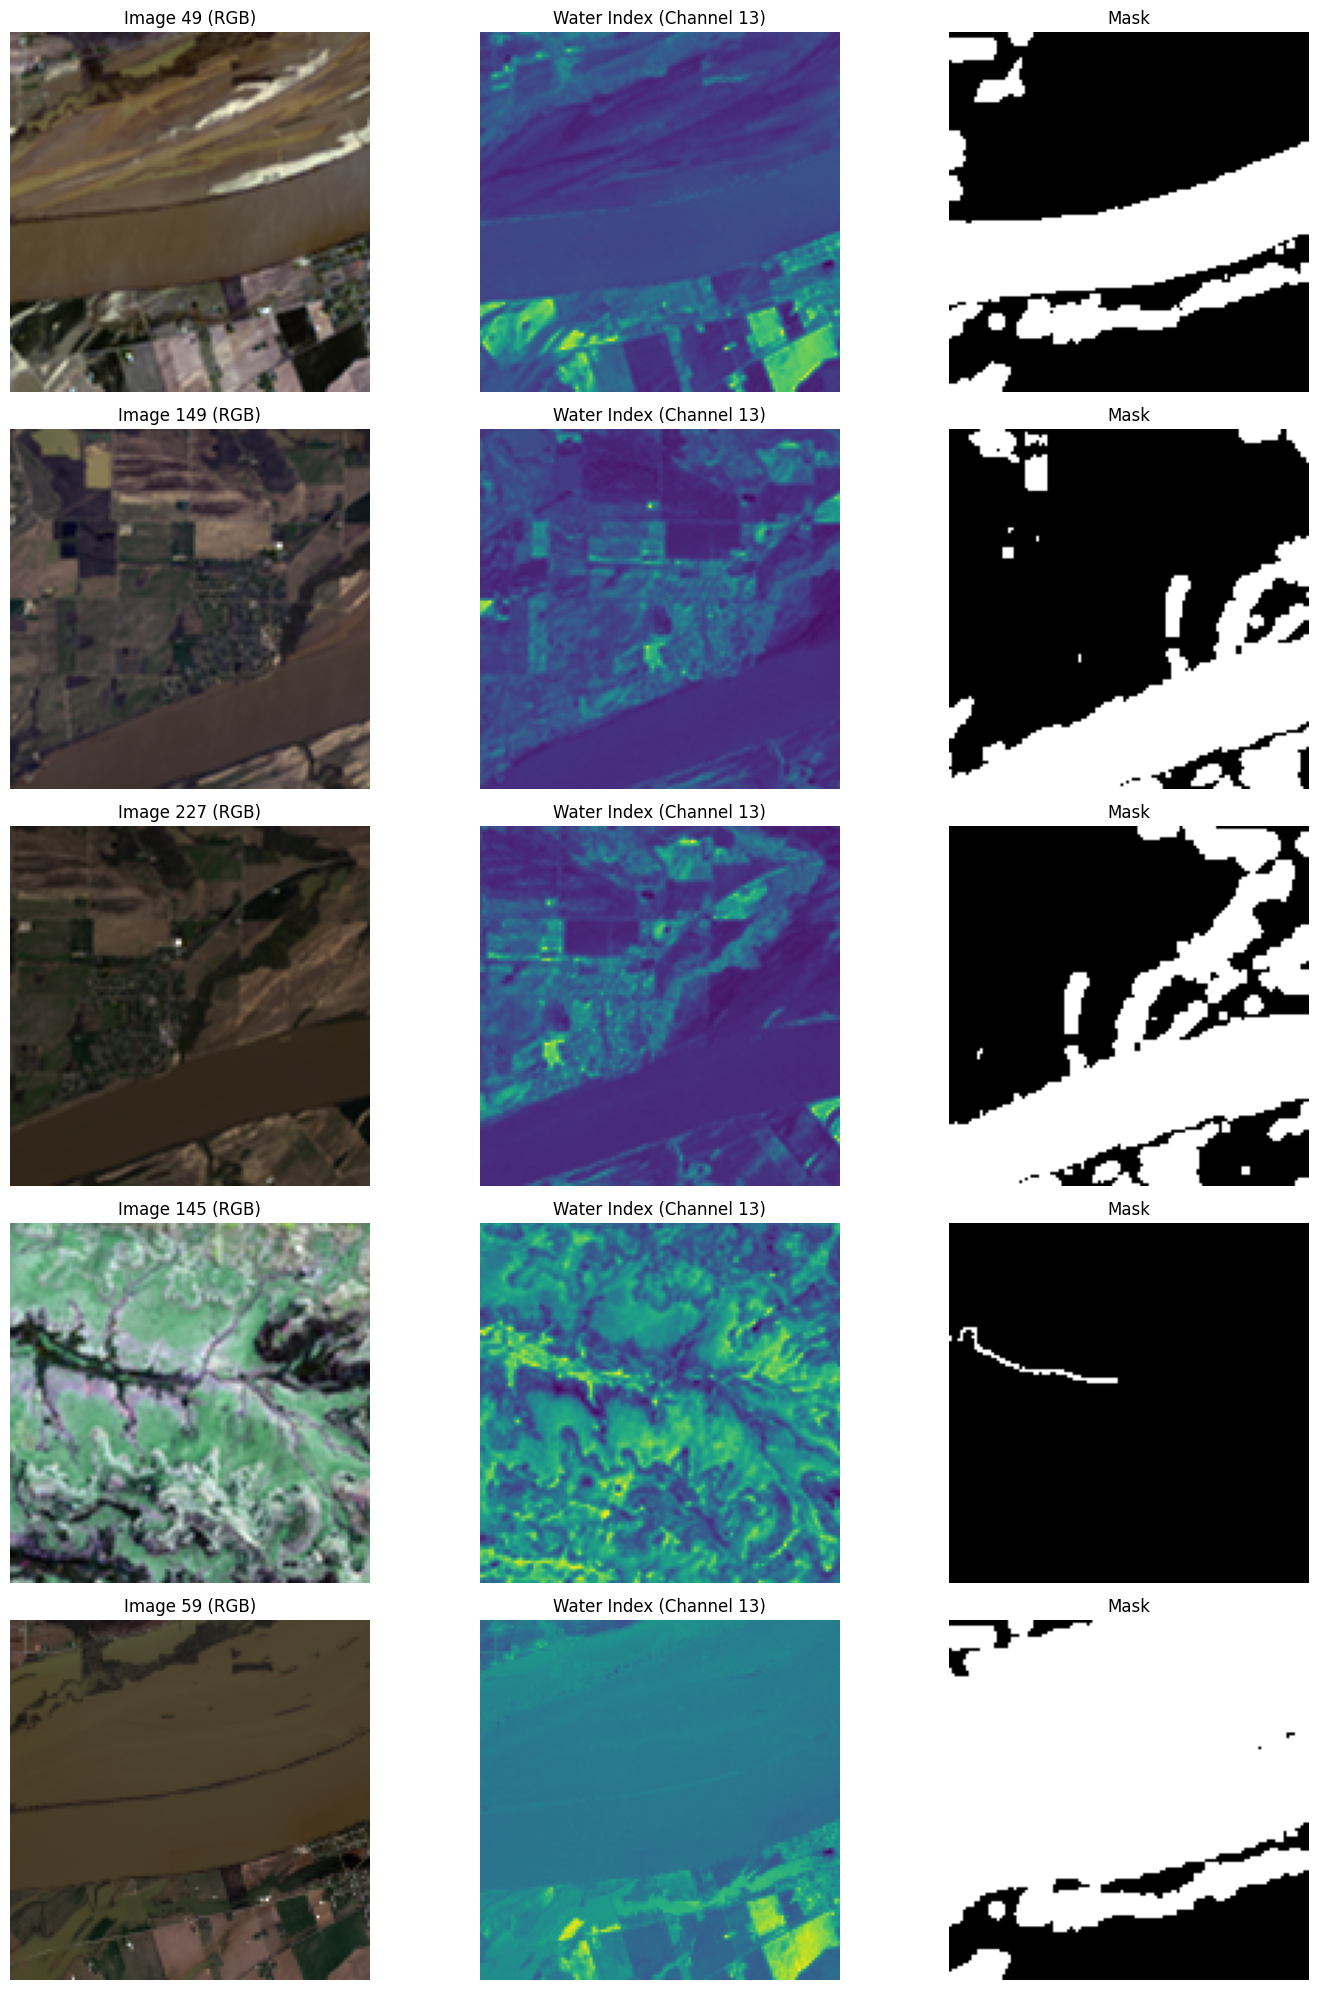

In [11]:
import matplotlib.pyplot as plt
import random
def display_sample_with_water_index(images, masks, num_samples=5, water_index_channel=12):
  plt.figure(figsize=(15, num_samples * 4))
  for i in range(num_samples):
    idx=random.randint(0, len(scaled_images)-1)
    img=scaled_images[idx][:, :, [3,2,1]]
    water_index=scaled_images[idx][:, :, water_index_channel]
    mask=masks[idx][:, :,0]

    plt.subplot(num_samples, 3, 3*i+1)
    plt.imshow(img)
    plt.title(f"Image {idx+1} (RGB)")
    plt.axis('off')

    plt.subplot(num_samples, 3, 3*i+2)
    plt.imshow(water_index, cmap='viridis', vmin=0, vmax=1)
    plt.title(f"Water Index (Channel {water_index_channel+1})")
    plt.axis('off')

    plt.subplot(num_samples, 3, 3*i+3)
    plt.imshow(mask, cmap='gray')
    plt.title("Mask")
    plt.axis('off')

  plt.tight_layout()
  plt.show()

display_sample_with_water_index(scaled_images,masks)

In [12]:
from sklearn.model_selection import train_test_split

X_temp, X_test, y_temp, y_test, filenames_temp, filenames_test = train_test_split(
    scaled_images, masks, filenames, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val, filenames_train, filenames_val = train_test_split(
    X_temp, y_temp, filenames_temp, test_size=0.1, random_state=42)

print("test files: ")
print(filenames_test)

print("Train: ",X_train.shape, y_train.shape)
print("Validation: ",X_val.shape, y_val.shape)
print("Test: ",X_test.shape, y_test.shape)

test files: 
['13.tif', '246.tif', '272.tif', '176.tif', '261.tif', '9.tif', '294.tif', '206.tif', '109.tif', '29.tif', '124.tif', '213.tif', '199.tif', '39.tif', '74.tif', '24.tif', '18.tif', '104.tif', '42.tif', '283.tif', '145.tif', '223.tif', '119.tif', '161.tif', '98.tif', '242.tif', '6.tif']
Train:  (210, 128, 128, 13) (210, 128, 128, 1)
Validation:  (24, 128, 128, 13) (24, 128, 128, 1)
Test:  (27, 128, 128, 13) (27, 128, 128, 1)


In [13]:
!pip install segmentation-models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.4 MB/s eta 0:00:00


#Feature Extraction Approach#


In [14]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

import segmentation_models as sm
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import numpy as np

BACKBONE = 'efficientnetb0'
preprocess_input = sm.get_preprocessing(BACKBONE)

def build_pretrained_unet(input_shape=(128, 128, 13)):
    inp = Input(shape=input_shape)

    x = Conv2D(16, (3,3), padding='same')(inp)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(3, (3,3), padding='same')(x)

    base_model = sm.Unet(
        backbone_name=BACKBONE,
        input_shape=(128, 128, 3),
        encoder_weights='imagenet',
        classes=1,
        activation='sigmoid'
    )

    output = base_model(x)
    model = Model(inputs=inp, outputs=output)
    model.base_model = base_model
    return model

model = build_pretrained_unet()

model.compile(
    optimizer=Adam(1e-4),
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score]
)

y_train = y_train.astype('float32')
y_val = y_val.astype('float32')
y_test = y_test.astype('float32')

callbacks = [
    EarlyStopping(monitor='val_loss', patience=7, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=60,
    batch_size=8,
)

Segmentation Models: using `tf.keras` framework.
16804768/16804768 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - iou_score: 0.2657 - loss: 1.5108 - val_iou_score: 0.3511 - val_loss: 1.5673
Epoch 2/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 48s 60ms/step - iou_score: 0.3241 - loss: 1.2714 - val_iou_score: 0.3826 - val_loss: 1.3390
Epoch 3/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - iou_score: 0.3659 - loss: 1.1220 - val_iou_score: 0.4228 - val_loss: 1.0832
Epoch 4/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - iou_score: 0.4423 - loss: 0.9599 - val_iou_score: 0.4286 - val_loss: 0.9875
Epoch 5/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - iou_score: 0.4665 - loss: 0.9066 - val_iou_score: 0.4349 - val_loss: 0.9542
Epoch 6/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - iou_score: 0.4694 - loss: 0.8866 - val_iou_score: 0.4523 - val_loss: 0.9183
Epoch 7/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - iou_score: 0.5385 - loss: 0.7693 - val_iou_score: 0.4776 - val_loss: 0.8

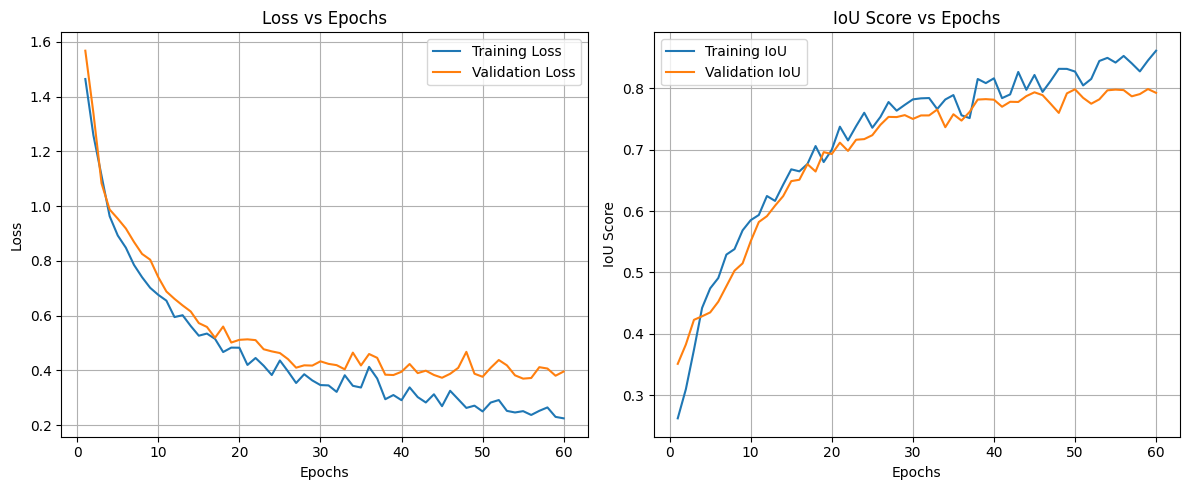

In [15]:
import matplotlib.pyplot as plt

# Extract training history
loss = history.history['loss']
val_loss = history.history['val_loss']
iou = history.history['iou_score']
val_iou = history.history['val_iou_score']

epochs = range(1, len(loss) + 1)

# Loss plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# IoU plot
plt.subplot(1, 2, 2)
plt.plot(epochs, iou, label='Training IoU')
plt.plot(epochs, val_iou, label='Validation IoU')
plt.title('IoU Score vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('IoU Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [16]:
results = model.evaluate(X_test, y_test, verbose=1)
print("Test Loss:", results[0])
print("Test IoU Score:", results[1])


1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step - iou_score: 0.8262 - loss: 0.3109
Test Loss: 0.31085336208343506
Test IoU Score: 0.8262427449226379


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
Sample 1 - File name: 74.tif
Sample 2 - File name: 283.tif
Sample 3 - File name: 98.tif
Sample 4 - File name: 24.tif
Sample 5 - File name: 13.tif
Sample 6 - File name: 104.tif
Sample 7 - File name: 6.tif
Sample 8 - File name: 242.tif
Sample 9 - File name: 9.tif
Sample 10 - File name: 213.tif


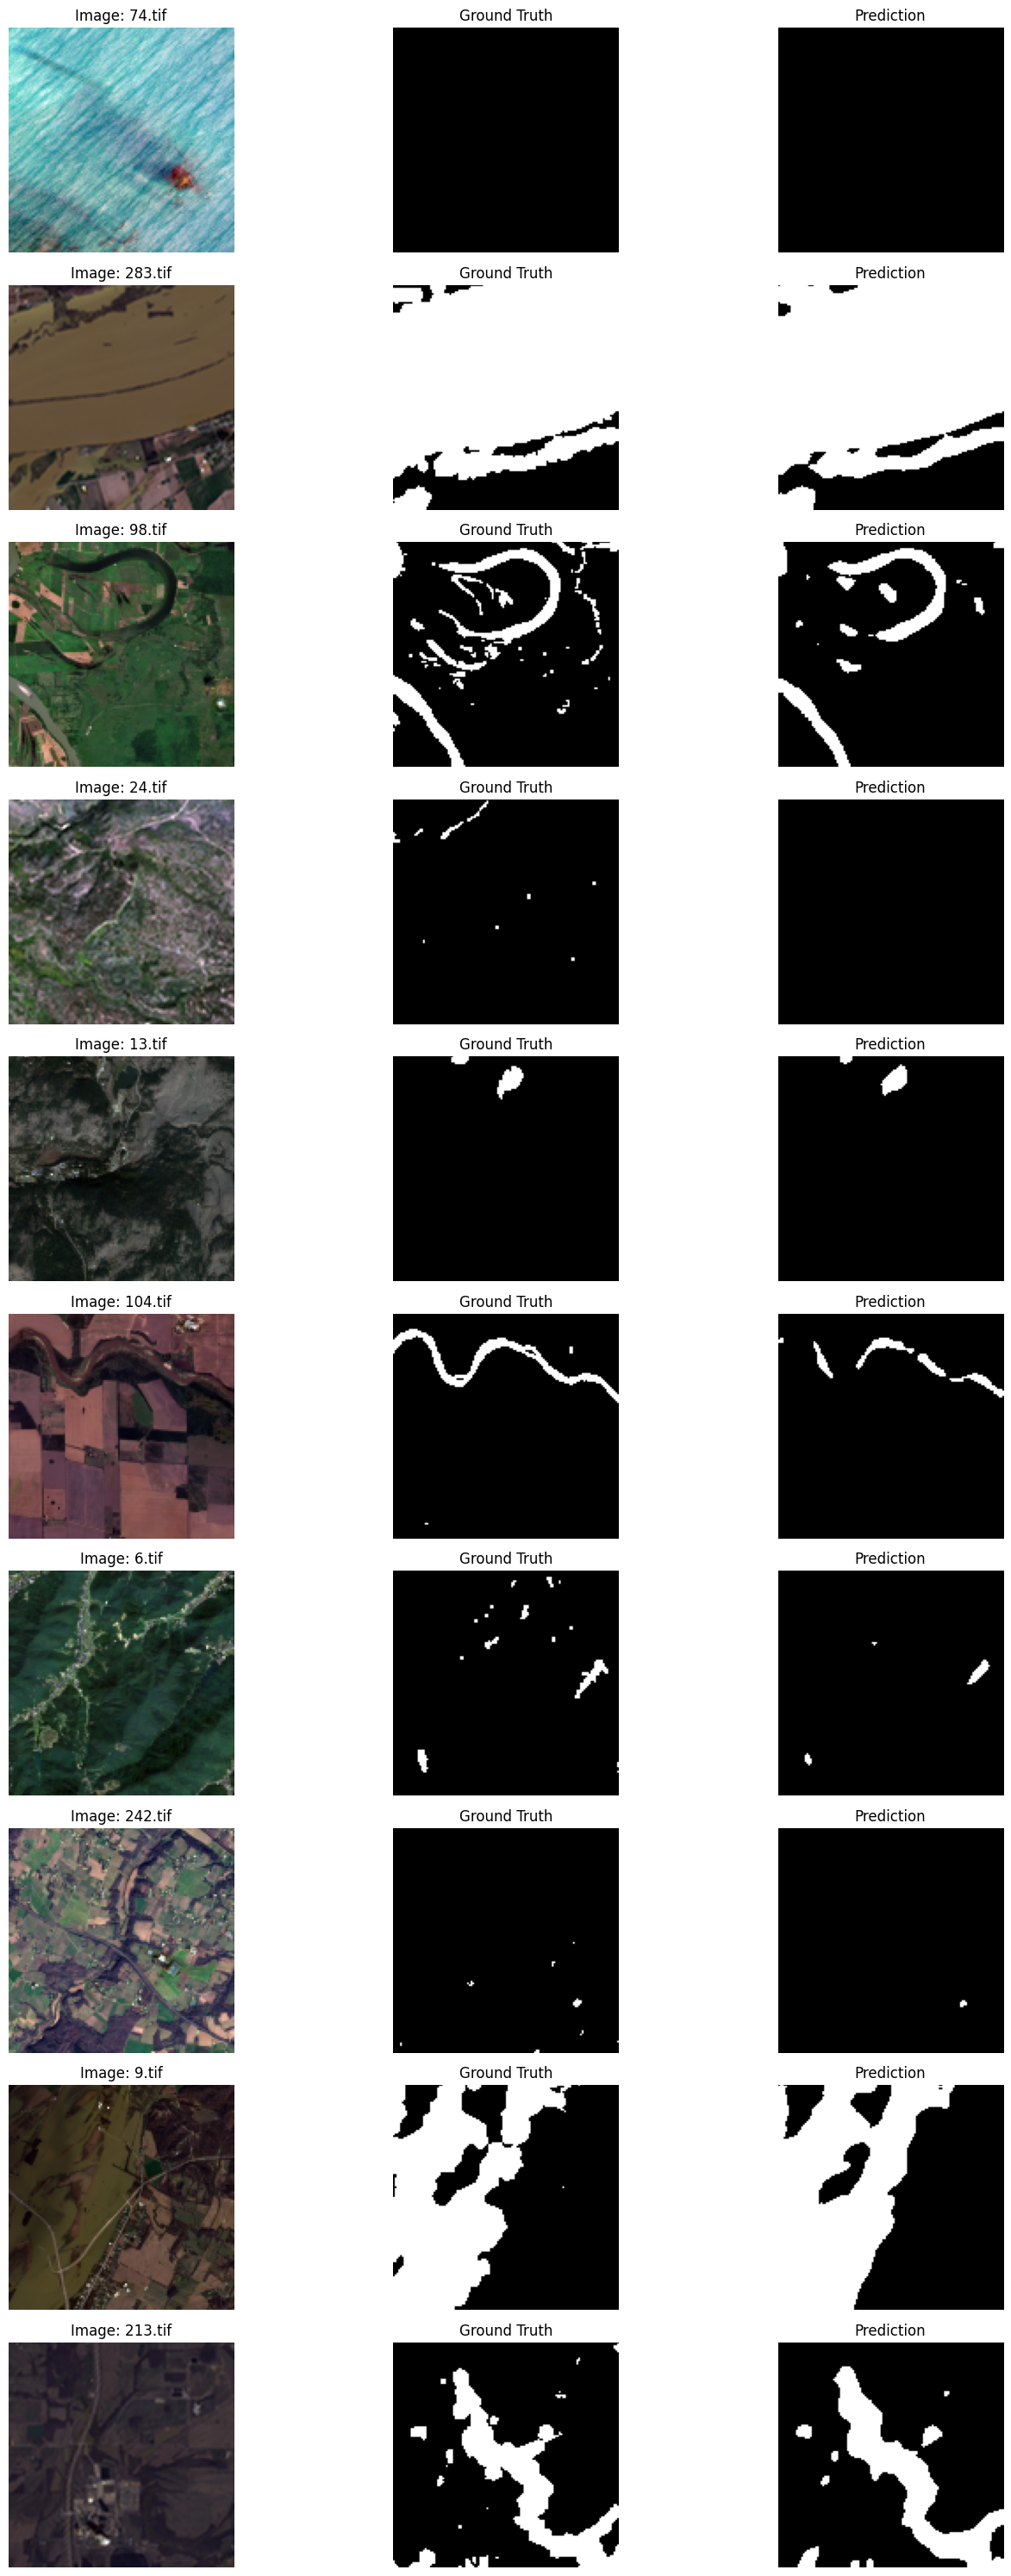

In [17]:
import matplotlib.pyplot as plt

def show_predictions(model, X, y_true, filenames, num_samples=5):
    indices = np.random.choice(len(X), num_samples, replace=False)
    preds = model.predict(X[indices])

    plt.figure(figsize=(15, num_samples * 3))

    for i, idx in enumerate(indices):
        img_rgb = X[idx][:,:, [3,2,1]]  # G B R -> visual
        mask_true = y_true[idx].squeeze()
        mask_pred = (preds[i].squeeze() > 0.5).astype(np.uint8)  # binary
        filename = filenames[idx]

        print(f"Sample {i+1} - File name: {filename}")  # طباعة اسم الصورة

        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(img_rgb)
        plt.title(f"Image: {filename}")
        plt.axis("off")

        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(mask_true, cmap='gray')
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(mask_pred, cmap='gray')
        plt.title("Prediction")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_predictions(model, X_test, y_test, filenames_test, num_samples=10)

In [18]:
model.save('Freezed Segmentation Model.h5')

In [19]:
from keras.models import load_model
model= load_model('Freezed Segmentation Model.h5',compile=False)

#Fine Tuning Approach#

In [20]:
def build_FineTuned(input_shape=(128, 128, 13)):
    inp = Input(shape=input_shape)

    x = Conv2D(16, (3,3), padding='same')(inp)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(3, (3,3), padding='same')(x)

    base_model = sm.Unet(
        backbone_name=BACKBONE,
        input_shape=(128, 128, 3),
        encoder_weights='imagenet',
        classes=1,
        activation='sigmoid'
    )

    output = base_model(x)
    model = Model(inputs=inp, outputs=output)
    model.base_model = base_model
    return model
Tuned_Model = build_FineTuned()

In [22]:
encoder = Tuned_Model.get_layer("functional_2")

for layer in encoder.layers:
    layer.trainable = False

for layer in encoder.layers[-40:]:
    layer.trainable = True

Tuned_Model.compile(
    optimizer=Adam(1e-5),
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score]
)
Tuned_Model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 13)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 16)   │         1,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 3)    │           435 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_2 (Functional)       │ (None, 128, 128, 1)    │    10,115,501 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,117,888 (38.60 MB)

 Trainable params: 6,066,308 (23.14 MB)

 Non-trainable params: 4,051,580 (15.46 MB)

In [23]:
history = Tuned_Model.fit(
    X_train, y_train,
    validation_data=(X_val,y_val),
    epochs=200
)


Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 82s 6s/step - iou_score: 0.2209 - loss: 1.5464 - val_iou_score: 0.3192 - val_loss: 1.6344
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - iou_score: 0.2350 - loss: 1.5221 - val_iou_score: 0.3139 - val_loss: 1.5904
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - iou_score: 0.2532 - loss: 1.4940 - val_iou_score: 0.3093 - val_loss: 1.5573
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - iou_score: 0.2481 - loss: 1.4913 - val_iou_score: 0.3055 - val_loss: 1.5338
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - iou_score: 0.2536 - loss: 1.4781 - val_iou_score: 0.3023 - val_loss: 1.5167
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - iou_score: 0.2737 - loss: 1.4460 - val_iou_score: 0.3003 - val_loss: 1.5028
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - iou_score: 0.2686 - loss: 1.4461 - val_iou_score: 0.3004 - val_loss: 1.4895
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - iou_score: 0.2649 - loss: 1.4406 - val_iou_sco

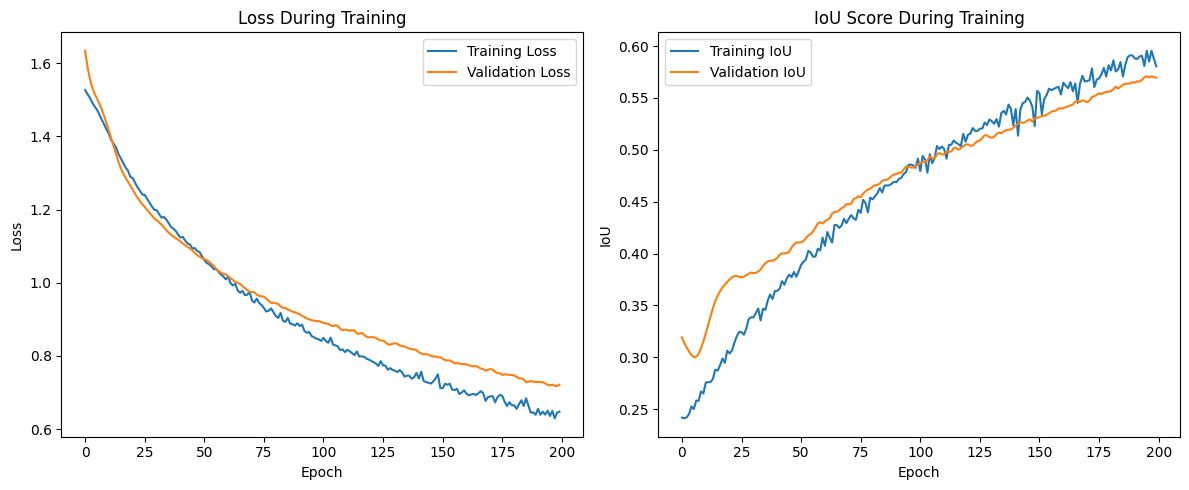

In [24]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['iou_score'], label='Training IoU')
    plt.plot(history.history['val_iou_score'], label='Validation IoU')
    plt.title('IoU Score During Training')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [25]:
results = Tuned_Model.evaluate(X_test, y_test, verbose=1)
print("Test Loss:", results[0])
print("Test IoU Score:", results[1])


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - iou_score: 0.5399 - loss: 0.7210
Test Loss: 0.7209827899932861
Test IoU Score: 0.5399361252784729


In [ ]:
#I think the best model is the first one